In [2]:
import os
import cv2
import imageio
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from scipy import io
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import KMeans
from scipy.spatial import distance_matrix

In [3]:
gt_path = 'BSR\\BSDS500\\data\\groundTruth\\test'
pics = os.listdir(gt_path)[0:50]

# create ground truth array

groundTruth = []

for filename in pics:

    data = io.loadmat(os.path.join(gt_path, filename))
    c = data['groundTruth'].shape[1]

    groundTruthPerImage = []
    for n in range(c):
        edge_data = data['groundTruth'][0][n][0][0][0]
        groundTruthPerImage.append(edge_data)

    groundTruthPerImage = np.array(groundTruthPerImage)
    groundTruth.append(groundTruthPerImage)

groundTruth = np.array(groundTruth,dtype=object)

#plt.imshow(groundTruth[0][0])
#plt.show()

In [4]:
#####################################################################################

root = "BSR\\BSDS500"
PATH = os.path.join(root, 'data\\groundTruth\\test')

save_pth = os.path.join(root, 'data\\converted_mat_jpg', 'test')
os.makedirs(save_pth, exist_ok=True)  #to save gt converted images
pics = os.listdir(PATH)[0:50]

# create converted images for ground truth segmentation
i = 0
for filename in pics:
    data = io.loadmat(os.path.join(PATH, filename))
    c = data['groundTruth'].shape[1]
    for n in range(c):
        edge_data = data['groundTruth'][0][n][0][0][1]
        edge_data_255 = edge_data * 255
        new_img_name = filename.split('.')[0] + '(' + str(n) + ')' + '.jpg'
        imageio.imwrite(os.path.join(save_pth, new_img_name), edge_data_255)  # save Picture
        pics[i] = filename.split('.')[0] + '.jpg'
    i = i + 1


# Visualize the image and the ground truth segmentation

root = "BSR\\BSDS500\\data\\images\\test"
converted = "BSR\\BSDS500\\data\\converted_mat_jpg\\test"

for filename in pics:
    gt = []
    im = Image.open(os.path.join(root, filename))

    for file in os.listdir(converted):
        if file.startswith(filename.split('.')[0]):
            gt.append(file)

    new_im = Image.new('RGB', (im.width * (len(gt) + 1), im.height))  #HORIZONTAL CONCAT
    new_im.paste(im, (0, 0))

    for i in range(len(gt)):
        im_gt = Image.open(os.path.join(converted, gt[i]))
        new_im.paste(im_gt, (im.width * (i + 1), 0))
    #plt.imshow(new_im)
    #plt.show()

#####################################################################################

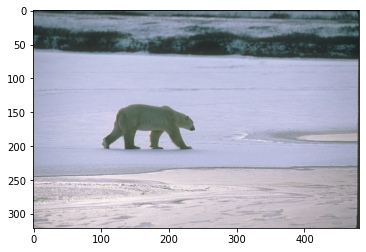

In [5]:
# original images

images = []

images_path = "BSR\\BSDS500\\data\\images\\test\\"

for filename in pics:
    img = cv2.imread(os.path.join(images_path, filename))
    im_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    images.append(im_rgb)

images = np.array(images, dtype=object)
plt.imshow(images[0])
plt.show()

flattened_images = np.empty((0, 3))

for i in range(1):
    flattened_image = images[i].reshape(images[i].shape[0] * images[i].shape[1], images[i].shape[2])
    flattened_images = np.concatenate((flattened_images, flattened_image))

In [10]:
from scipy.spatial import distance
from random import choice
def kmeans(k,data):
    
    n_clusters=[]
    est_labels=[]
    dist=[]
    labels=np.empty(data.shape[0], dtype=float) 
    
    x=data[:,0]
    y=data[:,1]
    z=data[:,2]
    it=0
    
    #get clusters init values
    for i in range(k):
            n_clusters.append(np.array([choice(x),choice(y),choice(z)]))
    print(data.shape)
    print(data[0])
       
    while(it<100):
        est_labels.clear()
    
        for i in range(data.shape[0]):
            dist.clear()
            for j in range(k):
                dist.append(np.linalg.norm(data[i] - n_clusters[j]))
            est_labels.append(np.argmin(np.array(dist)))
        
        count_arr = np.bincount(labels)
        
        if np.array_equal(np.array(est_labels),labels):
            it=1000
        else:
            labels=np.array(est_labels)
            #update
            for i in range(labels):
                update[ labels[i] ] += data[i]
            for i in range(k):
                n_clusters[i]=update[i]/count_arr[i]
        
        
    return labels.reshape(labels.shape[0], 1)
labels=kmeans(3,flattened_images)

(154401, 3)
[55. 73. 73.]


TypeError: Cannot cast array data from dtype('float64') to dtype('int64') according to the rule 'safe'

In [ ]:
# k = 3 5 7 9 11
def image_segmentation(k):
    segmented_images = []
    flat_segmented_images = []

    labels = kmeans(k,flattened_images)
    
    # build segmented images from clustering labels
    index = 0
    for i in range(1):
        size = images[i].shape[0] * images[i].shape[1]
        flat_segmentation = labels[index:size + index]

        segmented_images.append(flat_segmentation.reshape(images[i].shape[0], images[i].shape[1]))

        flat_segmented_images.append(flat_segmentation)
        index += size

    flat_segmented_images = np.array(flat_segmented_images, dtype=object)

    return segmented_images, flat_segmented_images

In [ ]:
def recreate_groundTruth(image_index, gt_index, flat_segmented_images, k):

    import sklearn.metrics.cluster as sk
    from scipy.optimize import linear_sum_assignment

    flattened_gt = np.array(groundTruth[image_index][gt_index]).reshape(
        images[image_index].shape[0] * images[image_index].shape[1], 1)


    # add dummy classes to match k clusters in case ground truth clusters < k
    max_gt = flattened_gt.max()
    if max_gt < k:
        j = 1
        for i in range(max_gt,k+1):
            flattened_gt[i][0] = max_gt + j
            j+=1

     # add dummy classes to match k clusters in case k_means classes < k
    max_seg = flat_segmented_images.max()
    if max_seg < k:
        j = 1
        for i in range(max_seg,k+1):
            flat_segmented_images[i] = max_seg + j
            j+=1

    contingency_matrix = sk.contingency_matrix(flattened_gt, flat_segmented_images)
    gt_clusters = contingency_matrix.shape[0]

    # max matching

    idx = linear_sum_assignment(-contingency_matrix.T)[1]
    for i in range(k):
        contingency_matrix[[idx[i], i]] = contingency_matrix[[i, idx[i]]]
        replaced_index = np.argwhere(flattened_gt == (idx[i]+1))
        # give the major k clusters new values
        flattened_gt[replaced_index] = gt_clusters + i + 1

    # give the minor clusters (which will be merged into the major clusters) new values
    values_gt = np.unique(flattened_gt)
    for i in range(gt_clusters - k):
        replaced_index = np.argwhere(flattened_gt == (values_gt[i]))
        flattened_gt[replaced_index] = gt_clusters + k + i + 1


    # merge the minor clusters into the major clusters
    contingency_matrix = sk.contingency_matrix(flattened_gt, flat_segmented_imgs[image_index])
    for i in range(k,gt_clusters):
        replaced_index = np.argwhere(flattened_gt == (gt_clusters + i + 1))
        flattened_gt[replaced_index] = gt_clusters + np.argmax(contingency_matrix[i]) + 1
        contingency_matrix[np.argmax(contingency_matrix[i])] += contingency_matrix[i]
    contingency_matrix = contingency_matrix[:k,:]


    new_gt = flattened_gt.reshape((images[image_index].shape[0], images[image_index].shape[1]))

    return new_gt,contingency_matrix

In [ ]:
def evaluate_segmentation(image_index, gt_index, flat_segmented_images, k):

    new_gt,contingency_matrix = recreate_groundTruth(image_index,gt_index,flat_segmented_images,k)

    # calculate F-score

    precision = np.zeros((k, 1))
    recall = np.zeros((k, 1))
    f_score = np.zeros((k, 1))

    for i in range(k):
        TP = np.amax(contingency_matrix[:, i])
        precision[i] = TP / np.sum(contingency_matrix[:, i])
        recall[i] = TP / np.sum(contingency_matrix[i])

        f_score[i] = (2 * precision[i] * recall[i]) / (precision[i] + recall[i])

    f_score_avg = np.mean(f_score)

    #############################################################################

    # calculate conditional Entropy

    pixels_count = images[image_index].shape[0] * images[image_index].shape[1]
    entropy = 0
    for i in range(k):
        sum_cluster = np.sum(contingency_matrix[:, i])

        H_cluster = 0
        for j in range(k):
            n_ij = contingency_matrix[i][j]
            if n_ij != 0:
                H_cluster += (n_ij / pixels_count) * np.log10(n_ij / sum_cluster)

        entropy -= H_cluster

    #############################################################################

    return f_score_avg, entropy , new_gt

In [ ]:
k_clusters = [3]

fig, ax = plt.subplots(1, 5, figsize=(35, 10))
seg_fig, seg_axs = plt.subplots(50, 5, figsize=(70, 500))

for k in k_clusters:

    plot = k_clusters.index(k)

    F_score_entropy_list = np.zeros((50, 2))
    segmented_imgs, flat_segmented_imgs = image_segmentation(k=k)

    for img_index in range(1):
        seg_axs[img_index][plot].imshow(segmented_imgs[img_index])

        seg_f_score_avg = 0
        seg_entropy_avg = 0
        gt_count = len(groundTruth[img_index])

        for gt_img_index in range(gt_count):
            F_score, Entropy,_ = evaluate_segmentation(img_index, gt_img_index, flat_segmented_imgs[img_index], k=k)
            seg_f_score_avg += F_score
            seg_entropy_avg += Entropy

        seg_f_score_avg /= gt_count
        seg_entropy_avg /= gt_count

        F_score_entropy_list[img_index][0] = seg_f_score_avg
        F_score_entropy_list[img_index][1] = seg_entropy_avg

    print("for k = {} : F-score per dataset: {}   Entropy per dataset: {}".format(k, np.sum(
        F_score_entropy_list[:, 0]) / 50, np.sum(F_score_entropy_list[:, 1]) / 50))

    ax[plot].set_axis_off()
    table = ax[plot].table(
        cellText=F_score_entropy_list,
        rowLabels=[r + 1 for r in range(50)],
        colLabels=["Average F-score", "Average Conditional Entropy"],
        cellLoc='center',
        loc='upper left')
    table.scale(1, 5)
    ax[plot].set_title('for k = {}'.format(k))

plt.show()

In [ ]:
segmented_imgs, flat_segmented_imgs = image_segmentation(k=5)
for img_index in range(1):
    fig, axs = plt.subplots(1, 6, figsize=(100, 20))
    axs[0].imshow(segmented_imgs[img_index] + 1)
    axs[0].set_title("Segmentation")

    for gt_img_index in range(len(groundTruth[img_index])):
        _, _,_new_gt = evaluate_segmentation(img_index, gt_img_index, flat_segmented_imgs[img_index], k=5)
        axs[gt_img_index + 1].imshow(_new_gt)

In [ ]:
# resize and get distance matrix
dist_mat=[]
for i in range(1):
    resized_image = cv2.resize(images[i], (100, 100))
    flattened_image = resized_image.reshape(resized_image.shape[0] *resized_image.shape[1], resized_image.shape[2])
    dist_mat.append(distance_matrix(flattened_image,flattened_image,p=2))
dist_mat=np.array(dist_mat)

In [ ]:
def Ncut(dist_mat, k, knn):

  #lab. mat
  A = kneighbors_graph(dist_mat , knn , mode='connectivity', include_self=False).toarray()
  D = np.diag(np.sum(A, axis=1))
  L = D - A

  #eigen
  eigen_values, eigen_vectors = np.linalg.eig(np.dot(np.linalg.inv(D),L))
  
  idx = eigen_values.argsort()[::1]
  eigen_values = eigen_values[idx]
  eigen_vectors = eigen_vectors[:,idx]

  Y = np.zeros(eigen_vectors.shape)
  for i in range(eigen_vectors.shape[0]):
    norm=np.linalg.norm(eigen_vectors[i])
    Y[i]=eigen_vectors[i]/norm
  
  km = KMeans(n_clusters=k).fit(Y)
  return km.labels_

In [ ]:
n_segmented=[]
for i in range(1):
    n_segmented.append(Ncut(dist_mat[i],k=5,knn=5))
n_segmented=np.array(n_segmented)

In [ ]:
for img_index in range(1):
    fig, axs = plt.subplots(1, 7, figsize=(100, 20))
    axs[0].imshow(n_segmented[img_index].reshape((100,100)))
    axs[0].set_title("N_Segmentation")
    axs[1].imshow(segmented_imgs[img_index])
    axs[1].set_title("k_Segmentation")
    for gt_img_index in range(len(groundTruth[i])):
        axs[gt_img_index + 2].imshow(groundTruth[img_index][gt_img_index])

In [ ]:
images=None
segmented_imgs=None
groundTruth=None
groundTruthPerImage=None